In [1]:
import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import locatingFuncs as lF
import illustrisFuncs as iF
import funcs
import matplotlib as mpl
from matplotlib.patches import Rectangle
from os.path import isfile

import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

plt.style.use('fancy_plots2.mplstyle')

# in-situ stellar mass fraction vs galaxy/halo mass

In [15]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

fig_snap = 99

f = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/galaxies_' + str(fig_snap).zfill(3) + '.hdf5','r')
stellar_mass = f['StellarMassTotal'][:] * 1e10 / h_const
exsitu_stellar_mass = f['StellarMassExSitu'][:] * 1e10 / h_const
f.close()

print('masses loaded',flush = True)

f = h5py.File('/vera/ptmp/gc/olwitt/auxCats/' + basePath[32:39] + f'/StellarAssembly_{fig_snap}.hdf5','r')
situ_cat = f['stellar_assembly'][:]
subhaloFlag = f['subhalo_flag'][:]
f.close()

print('situ cats loaded',flush = True)

g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_' + str(fig_snap).zfill(3) + '.hdf5','r')
starsInSubOffset = g['Subhalo/SnapByType'][:,4]
g.close()

print('offsets loaded',flush = True)

numStarsInSubs = il.groupcat.loadSubhalos(basePath, fig_snap, fields = ['SubhaloLenType'])[:,4]

print('lengths loaded',flush = True)

insitu_stellar_mass = stellar_mass - exsitu_stellar_mass
medsitu_stellar_mass = np.zeros(stellar_mass.shape[0])
for i in range(subhaloFlag.shape[0]):
    if subhaloFlag[i] == 0:
        continue
    indices = np.arange(starsInSubOffset[i], starsInSubOffset[i] + numStarsInSubs[i])
    if indices.shape[0] > 0:
        insitu = np.where(situ_cat[indices] == 1)[0]
        medsitu = np.where(situ_cat[indices] == 2)[0]
        medsitu_stellar_mass[i] = stellar_mass[i] * medsitu.shape[0]/indices.shape[0]
        insitu_stellar_mass[i] = stellar_mass[i] * insitu.shape[0]/indices.shape[0]
print('done',flush = True)

masses loaded
situ cats loaded
offsets loaded
lengths loaded
done


(12275,)


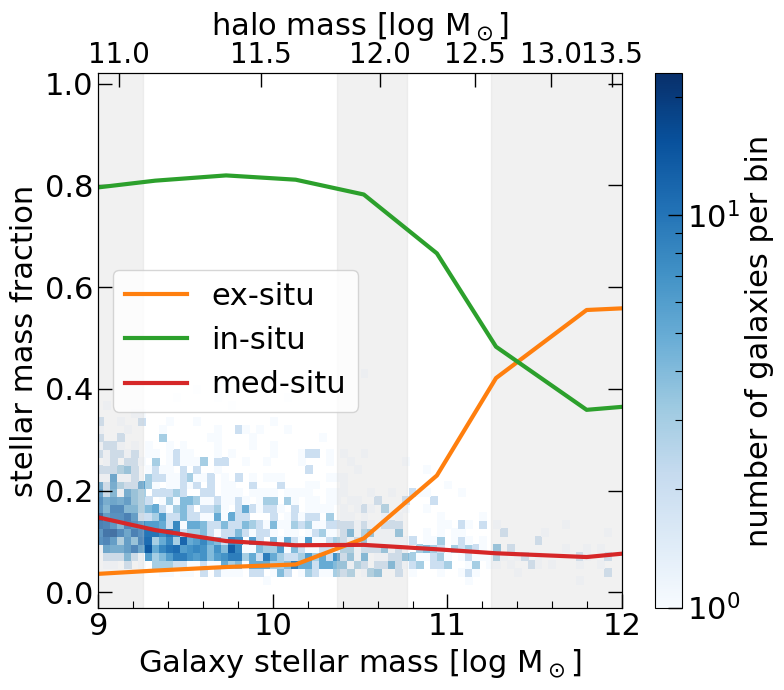

In [25]:
sub_mask = np.nonzero(subhaloFlag)[0]
print(sub_mask.shape)
infracs = insitu_stellar_mass[sub_mask] / stellar_mass[sub_mask]
medfracs = medsitu_stellar_mass[sub_mask] / stellar_mass[sub_mask]
exfracs = exsitu_stellar_mass[sub_mask] / stellar_mass[sub_mask]

log_stellar_mass = np.log10(stellar_mass[sub_mask])

mass_bins, ex_bins, exy16, exy84 =  funcs.binData_med(log_stellar_mass, exfracs, 20)
_, in_bins, iny16, iny84 =  funcs.binData_med(log_stellar_mass, infracs, 20)
_, med_bins, medy16, medy84 =  funcs.binData_med(log_stellar_mass, medfracs, 20)

# mask = np.where(stellar_mass > 8.5)

mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22

fig, ax = plt.subplots(1,1, figsize = (8,7))
plt.hist2d(log_stellar_mass, medfracs, cmap = 'Blues',norm = mpl.colors.LogNorm(), bins = (200,64), rasterized = True)
cb = plt.colorbar()
cb.set_label(label='number of galaxies per bin',size = 22)
ax.plot(mass_bins, ex_bins, color = 'tab:orange', label = 'ex-situ')
ax.plot(mass_bins, in_bins, color = 'tab:green', label = 'in-situ')
ax.plot(mass_bins, med_bins, color = 'tab:red', label = 'med-situ')
# ax.fill_between(exsm_med, exy16,exy84,alpha = 0.3,color = 'tab:orange')
# ax.fill_between(insm_med, iny16,iny84,alpha = 0.3,color = 'tab:green')

plt.legend()
plt.xlim(9,12)
plt.ylim(-0.03,1.02)

# fig_snap = 33

# f = h5py.File(basePath[:-6]+f'postprocessing/StellarAssembly/galaxies_0{fig_snap}.hdf5','r')
# stellar_mass = f['StellarMassTotal'][:]
# exsitu_stellar_mass = f['StellarMassExSitu'][:]

# frac = exsitu_stellar_mass[np.where(stellar_mass>0)[0]] / stellar_mass[np.where(stellar_mass>0)[0]]
# stellar_mass = np.log10(stellar_mass[np.where(stellar_mass>0)[0]] * 1e10/h_const)
# f.close()

# exsm_med, exfrac_med, exy16, exy84 =  funcs.binData_med(stellar_mass, frac, 20)
# insm_med, infrac_med, iny16, iny84 =  funcs.binData_med(stellar_mass, 1 - frac, 20)

# order = np.argsort(stellar_mass)
# stellar_mass = stellar_mass[order]
# frac = frac[order]

# mask = np.where(stellar_mass > 8.5)

# ax.plot(exsm_med,exfrac_med,color = 'tab:orange', linestyle = 'dotted')
# ax.plot(insm_med,infrac_med,color = 'tab:green', linestyle = 'dotted')


group_m = np.array([6.86093282699585, 7.398449420928955, 7.901801109313965, 8.393900871276855, 8.886045455932617,\
                    9.339580535888672, 9.809768676757812, 10.323699951171875, 10.840004920959473, 11.344971656799316,\
                    11.868677139282227, 12.379907608032227, 12.879098892211914, 13.441740036010742, 13.891986846923828])
gal_m = np.array([4.742977619171143, 4.718081474304199, 4.761687278747559, 4.795966625213623, 4.861518859863281,\
                  5.147671699523926, 6.013262748718262, 7.66148042678833, 8.850899696350098, 9.708621978759766,\
                  10.465829849243164, 11.046808242797852, 11.511899948120117, 11.899462699890137, 12.20790958404541])
secax = ax.twiny()
from scipy import interpolate
f_interp = interpolate.interp1d(group_m, gal_m)
new_tick_locations = np.array([11.,11.5,12.,12.5,13.,13.5])
secax.set_xlim(ax.get_xlim())
secax.set_xticks(f_interp(new_tick_locations))
secax.set_xticklabels(new_tick_locations, size = 20)
secax.minorticks_off()
secax.set_xlabel(r'halo mass [log $\rm{M}_\odot$]', size = 22)

rec_dwarf = Rectangle((f_interp(10.8),-0.1),0.5,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_dwarf)
rec_mw = Rectangle((f_interp(11.8),-0.1),0.4,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_mw)
rec_group = Rectangle((f_interp(12.6),-0.1),0.8,1.2, color = 'lightgray', alpha = 0.3)
ax.add_patch(rec_group)


ax.set_xlabel(r'Galaxy stellar mass [log $\rm{M}_\odot$]', size = 22)
ax.set_ylabel('stellar mass fraction', size = 22)
fig.tight_layout()
#plt.grid()
plt.savefig(f'pics/ex-situ_in-situ_mass_fraction/ex-in-med-situ_mass_frac_50-{basePath[38]}.pdf',format = 'pdf')

plt.style.use('fancy_plots2.mplstyle')

# ex-situ fraction vs radial coordinate

In [14]:
@jit(nopython = True)
def ex_in_frac_binning(starType, distance, numBins, max_dist): 
    minVal = 0
    maxVal = max_dist
    
    binWidth = (maxVal - minVal) / numBins
    
    yMed = np.zeros(numBins)
    
    for j in range(numBins):
        relInd = np.where(np.logical_and(distance >= minVal + j*binWidth, distance < minVal + (j+1)*binWidth))[0]
        if(relInd.size>0):
            insitu = np.where(starType[relInd] == 1)[0].shape[0]
            exsitu = np.where(starType[relInd] == 0)[0].shape[0]
            yMed[j] = exsitu/(insitu + exsitu)# if insitu > 0 else np.nan
            
    return yMed

@jit(nopython = True, parallel = True)
def compute_profiles(sub_ids, num_bins, offsets, numPart_stars, sub_pos, starType, star_pos, boxSize,\
                                    group_R_Crit200, num_gmcrit200):
    sub_profiles = np.zeros((sub_ids.shape[0],num_bins))
    
    for i in nb.prange(sub_ids.shape[0]):
        offset = offsets[i]
        num_stars = numPart_stars[i]
        subhalo_pos = sub_pos[i,:]
        indcs = np.arange(offset,offset + num_stars)
        starType_sub = starType[indcs]        
        distances = funcs.dist_vector_nb(subhalo_pos,star_pos[indcs],boxSize) #/h_const
        
        #bin until max_dist times the stellar halfmass radius is reached
        max_dist = num_gmcrit200 * group_R_Crit200[i]#subs['SubhaloHalfmassRadType'][sub_ids[i],4]
        sub_profiles[i,:] = ex_in_frac_binning(starType_sub, distances, num_bins, max_dist)
    return sub_profiles

def exsitu_radial_profile(basePath, snap, sub_ids, group_R_Crit200, num_bins = 10, num_gmcrit200 = 2,\
                          star_pos = 0, subs = 0):
    """Computes (average) radial profile of given subhalos at specific snapshot up until max_dist times the
    stellar halfmass radius."""
    boxSize = il.groupcat.loadHeader(basePath,snap)['BoxSize']
    h_const = il.groupcat.loadHeader(basePath,snap)['HubbleParam']
    
    f = h5py.File(basePath[:-6]+'postprocessing/StellarAssembly/stars_' + str(snap).zfill(3) + '.hdf5','r')
    starType = f['InSitu'][:]
    f.close()
    
    g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_' + str(snap).zfill(3) + '.hdf5','r')
    offset = g['Subhalo/SnapByType'][sub_ids,4]
    g.close()
    
    numPart_stars = subs['SubhaloLenType'][sub_ids,4]
    sub_pos = subs['SubhaloPos'][sub_ids,:]
    
    sub_profiles = compute_profiles(sub_ids, num_bins, offset, numPart_stars, sub_pos, starType, star_pos, boxSize,\
                                    group_R_Crit200, num_gmcrit200)
    
    return sub_profiles

In [15]:
star_pos_99 = il.snapshot.loadSubset(basePath, 99, 4, fields = ['Coordinates'])
star_pos_33 = il.snapshot.loadSubset(basePath, 33, 4, fields = ['Coordinates'])

1/6
2/6
3/6
4/6
5/6
6/6
CPU times: user 1min 17s, sys: 12.7 s, total: 1min 30s
Wall time: 2min 9s


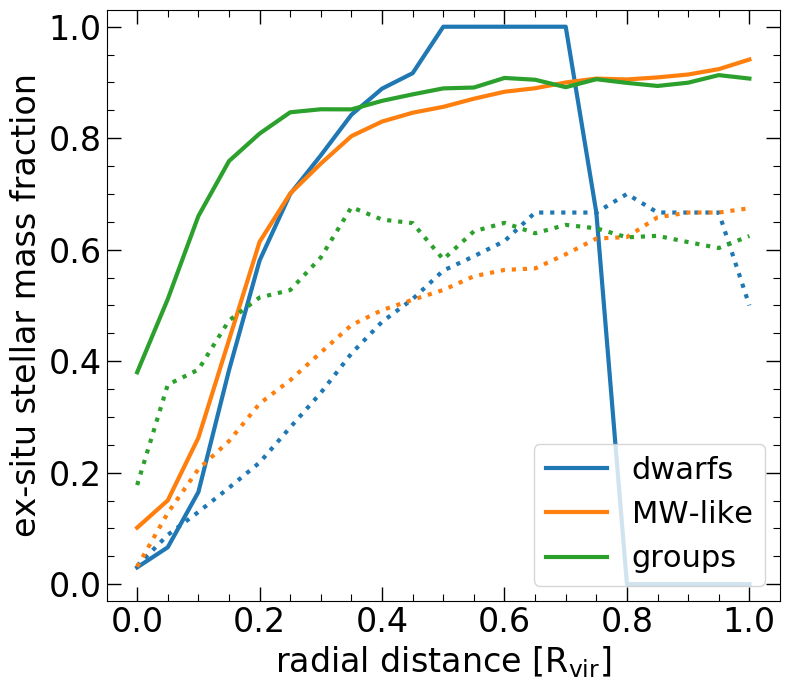

In [18]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-1/output'
start_snap = 99
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]

groupRcrit200_dwarves = groups['Group_R_Crit200'][dwarf_ids]
groupRcrit200_mw = groups['Group_R_Crit200'][mw_ids]
groupRcrit200_groups = groups['Group_R_Crit200'][group_ids]

numBins = 21
num_gmcrit200 = 1
dist_bins = np.linspace(0,num_gmcrit200,numBins)

star_pos = star_pos_99
subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloPos','SubhaloLenType','SubhaloHalfmassRadType'])
sub_profiles_dwarves = exsitu_radial_profile(basePath, start_snap, sub_ids_dwarves, groupRcrit200_dwarves,\
                                             numBins, num_gmcrit200, star_pos, subs)
print('1/6', flush = True)
sub_profiles_mw = exsitu_radial_profile(basePath, start_snap, sub_ids_mw, groupRcrit200_mw, numBins, num_gmcrit200,\
                                        star_pos, subs)
print('2/6', flush = True)
sub_profiles_groups = exsitu_radial_profile(basePath, start_snap, sub_ids_groups, groupRcrit200_groups,\
                                            numBins, num_gmcrit200, star_pos, subs)
print('3/6', flush = True)

fig, ax = plt.subplots(1,1, figsize = (8,7))
ax.plot(dist_bins, np.nanmedian(sub_profiles_dwarves,axis = 0),label = 'dwarfs', color = 'C0')
ax.plot(dist_bins, np.nanmedian(sub_profiles_mw,axis = 0),label = 'MW-like', color = 'C1')
ax.plot(dist_bins, np.nanmedian(sub_profiles_groups,axis = 0),label = 'groups', color = 'C2')
ax.legend(loc = 'lower right')

start_snap = 33
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub','Group_R_Crit200'])
group_masses = groups['Group_M_Crit200']*1e10/h_const

#differentiate between halos of dwarf / milky way / group size
dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

#find ids of associated centrals
sub_ids_dwarves = groups['GroupFirstSub'][dwarf_ids]
sub_ids_mw = groups['GroupFirstSub'][mw_ids]
sub_ids_groups = groups['GroupFirstSub'][group_ids]

groupRcrit200_dwarves = groups['Group_R_Crit200'][dwarf_ids]
groupRcrit200_mw = groups['Group_R_Crit200'][mw_ids]
groupRcrit200_groups = groups['Group_R_Crit200'][group_ids]

subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloPos','SubhaloLenType','SubhaloHalfmassRadType'])
del star_pos
star_pos = star_pos_33
sub_profiles_dwarves = exsitu_radial_profile(basePath, start_snap, sub_ids_dwarves, groupRcrit200_dwarves,\
                                             numBins, num_gmcrit200, star_pos, subs)
print('4/6', flush = True)
sub_profiles_mw = exsitu_radial_profile(basePath, start_snap, sub_ids_mw, groupRcrit200_mw, numBins, num_gmcrit200,\
                                        star_pos, subs)
print('5/6', flush = True)
sub_profiles_groups = exsitu_radial_profile(basePath, start_snap, sub_ids_groups, groupRcrit200_groups,\
                                            numBins, num_gmcrit200, star_pos, subs)
print('6/6', flush = True)

ax.plot(dist_bins, np.nanmedian(sub_profiles_dwarves,axis = 0), color = 'C0', linestyle = 'dotted')
ax.plot(dist_bins, np.nanmedian(sub_profiles_mw,axis = 0), color = 'C1', linestyle = 'dotted')
ax.plot(dist_bins, np.nanmedian(sub_profiles_groups,axis = 0), color = 'C2', linestyle = 'dotted')

#ax.set_yscale('log')
ax.set_xlabel(r'radial distance [$\rm{R}_{\rm{vir}}$]')
ax.set_ylabel('ex-situ stellar mass fraction')
ax.set_ylim(-0.03,1.03)
fig.tight_layout()

plt.savefig('pics/ex-situ_in-situ_mass_fraction/exsitu_frac_rad_profile_' + basePath[35:39] +\
            '_final.pdf', format = 'pdf')

# evolution of the in-situ stellar mass fraction